### One-step ahead forecasting approach:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# XGBoost
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# ✅ Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

from prophet.make_holidays import make_holidays_df

# Load training and test data
train = pd.read_csv("/content/drive/Shared drives/Time Series/divvy_data/prod/station/divvy_station_train.csv")
test = pd.read_csv("/content/drive/Shared drives/Time Series/divvy_data/prod/station/divvy_station_test.csv")

# Ensure dates are in datetime format
train['ds'] = pd.to_datetime(train['date'])
test['ds'] = pd.to_datetime(test['date'])
train.drop(columns=['date'], inplace=True)
test.drop(columns=['date'], inplace=True)

# Create a combined dataframe with a marker column
train['is_train'] = True
test['is_train'] = False
combined = pd.concat([train, test])

# Create lag features on the combined data
for lag in [1, 2, 7, 30, 60, 90, 365]:
    combined[f'y_lag{lag}'] = combined.groupby('start_station_name')['total_rides'].shift(lag)

# Feature engineering for XGBoost
for df in [combined]:
    df['day'] = df['ds'].dt.day
    df['month'] = df['ds'].dt.month
    df['year'] = df['ds'].dt.year
    df['weekday'] = df['ds'].dt.weekday
    df['week_of_year'] = df['ds'].dt.isocalendar().week
    df['is_weekend'] = df['weekday'].isin([5, 6]).astype(int)
    df['rain_intensity'] = pd.cut(df['rain_sum_mm'], bins=[-1, 0, 5, 20, np.inf], labels=[0, 1, 2, 3])
    df['snow_flag'] = (df['snowfall_sum_cm'] > 0).astype(int)
    df['rolling_avg_7'] = df.groupby('start_station_name')['total_rides'].transform(lambda x: x.shift(1).rolling(window=7, min_periods=1).mean())
    df['rolling_avg_30'] = df.groupby('start_station_name')['total_rides'].transform(lambda x: x.shift(1).rolling(window=30, min_periods=1).mean())
    df['ride_growth'] = df.groupby('start_station_name')['total_rides'].transform(lambda x: x.shift(7).pct_change(periods=7).fillna(0))
    df['rain_intensity'] = df['rain_intensity'].astype(float)
    df['weekend_rain'] = df['is_weekend'] * df['rain_intensity']
    df['cold_no_snow'] = (df['temp_min_c'] < 5) & (df['snow_flag'] == 0)

# Split back into train and test
train = combined[combined['is_train']].drop('is_train', axis=1)
test = combined[~combined['is_train']].drop('is_train', axis=1)

# Drop the datetime column, start_station_id
train.drop(columns=['ds', 'start_station_id'], inplace=True)
test.drop(columns=['ds', 'start_station_id'], inplace=True)

# Ensure only common stations exist in test before encoding
test = test[test['start_station_name'].isin(train['start_station_name'].unique())]

# One-hot encoding
train = pd.get_dummies(train, columns=['start_station_name'], drop_first=True)
test = pd.get_dummies(test, columns=['start_station_name'], drop_first=True)

# Align test columns with train columns
test = test.reindex(columns=train.columns, fill_value=0)

# Prepare data for XGBoost
X_train = train.drop(columns=['total_rides'])
y_train = train['total_rides']
X_test = test.drop(columns=['total_rides'])
y_test = test['total_rides']

best_params = {
    'colsample_bytree': 0.8,
    'learning_rate': 0.1,
    'max_depth': 10,
    'n_estimators': 1000,
    'subsample': 0.8
}

best_xgb_model = XGBRegressor(**best_params, random_state=42)
best_xgb_model.fit(X_train, y_train)

# Ensure test features match train
X_test = X_test[X_train.columns]

# Make predictions
y_pred = best_xgb_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# R-squared score
r2 = best_xgb_model.score(X_test, y_test)
print(f'R-squared: {r2}')

Mounted at /content/drive


<ipython-input-1-41f6a2e0af7c>:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv("/content/drive/Shared drives/Time Series/divvy_data/prod/station/divvy_station_train.csv")
<ipython-input-1-41f6a2e0af7c>:48: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['ride_growth'] = df.groupby('start_station_name')['total_rides'].transform(lambda x: x.shift(7).pct_change(periods=7).fillna(0))


Mean Squared Error: 89.69459533691406
R-squared: 0.892842710018158


In [ ]:
from sklearn.metrics import mean_absolute_error

# Function to calculate Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Function to calculate Symmetric Mean Absolute Percentage Error (sMAPE)
def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(2.0 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))) * 100

# Function to calculate Mean Absolute Scaled Error (MASE)
def mean_absolute_scaled_error(y_true, y_pred, y_train):
    naive_forecast = np.roll(y_train, shift=1)  # Naive forecast (previous value)
    naive_forecast[0] = y_train[0]  # First value remains same
    mae_naive = np.mean(np.abs(y_train - naive_forecast))  # Naive MAE
    return mean_absolute_error(y_true, y_pred) / mae_naive

# Compute metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
smape = symmetric_mean_absolute_percentage_error(y_test, y_pred)
mase = mean_absolute_scaled_error(y_test, y_pred, y_train)
r_squared = best_xgb_model.score(X_test, y_test)

# Create DataFrame for display
metrics_df = pd.DataFrame({
    "Metric": ["MAE", "MSE", "MAPE", "sMAPE", "MASE", "R-squared"],
    "Value": [mae, mse, mape, smape, mase, r_squared]
})

# Round the values in the metrics dataframe to two significant figures
metrics_df["Value"] = metrics_df["Value"].apply(lambda x: round(x, 2))

metrics_df

,Metric,Value
0,MAE,4.79
1,MSE,89.69
2,MAPE,48.67
3,sMAPE,35.38
4,MASE,0.23
5,R-squared,0.89


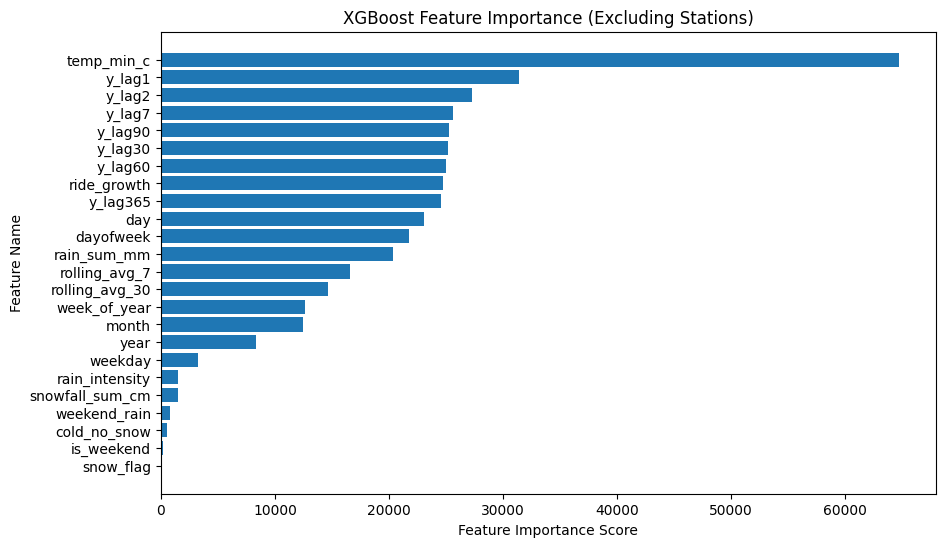

In [ ]:
# Get feature names
feature_names = X_train.columns

# Exclude one-hot encoded station features
filtered_features = [f for f in feature_names if not f.startswith("start_station_name_")]

# Get importance scores only for relevant features
importance = best_xgb_model.get_booster().get_score(importance_type="weight")

# Filter out station one-hot encoding
filtered_importance = {k: v for k, v in importance.items() if k in filtered_features}

# Sort features by importance
sorted_importance = sorted(filtered_importance.items(), key=lambda x: x[1], reverse=True)

# Plot the filtered feature importance
plt.figure(figsize=(10, 6))
plt.barh([x[0] for x in sorted_importance], [x[1] for x in sorted_importance])
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature Name")
plt.title("XGBoost Feature Importance (Excluding Stations)")
plt.gca().invert_yaxis()  # Highest importance at top
plt.show()

In [ ]:
metrics_df

,Metric,Value
0,MAE,4.79
1,MSE,89.69
2,MAPE,48.67
3,sMAPE,35.38
4,MASE,0.23
5,R-squared,0.89


### Station-level forecast, no lags (growth forecast)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# XGBoost
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# ✅ Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

from prophet.make_holidays import make_holidays_df

# Load training and test data
train = pd.read_csv("/content/drive/Shared drives/Time Series/divvy_data/prod/station/divvy_station_train.csv")
test = pd.read_csv("/content/drive/Shared drives/Time Series/divvy_data/prod/station/divvy_station_test.csv")

# Ensure dates are in datetime format
train['ds'] = pd.to_datetime(train['date'])
test['ds'] = pd.to_datetime(test['date'])
train.drop(columns=['date'], inplace=True)
test.drop(columns=['date'], inplace=True)

# Create a combined dataframe with a marker column
train['is_train'] = True
test['is_train'] = False
combined = pd.concat([train, test])

# Feature engineering for XGBoost
for df in [combined]:
    df['day'] = df['ds'].dt.day
    df['month'] = df['ds'].dt.month
    df['year'] = df['ds'].dt.year
    df['weekday'] = df['ds'].dt.weekday
    df['week_of_year'] = df['ds'].dt.isocalendar().week
    df['is_weekend'] = df['weekday'].isin([5, 6]).astype(int)
    df['rain_intensity'] = pd.cut(df['rain_sum_mm'], bins=[-1, 0, 5, 20, np.inf], labels=[0, 1, 2, 3])
    df['snow_flag'] = (df['snowfall_sum_cm'] > 0).astype(int)
    df['rain_intensity'] = df['rain_intensity'].astype(float)
    df['weekend_rain'] = df['is_weekend'] * df['rain_intensity']
    df['cold_no_snow'] = (df['temp_min_c'] < 5) & (df['snow_flag'] == 0)

# Split back into train and test
train = combined[combined['is_train']].drop('is_train', axis=1)
test = combined[~combined['is_train']].drop('is_train', axis=1)

# Drop the datetime column, start_station_id
train.drop(columns=['ds', 'start_station_id'], inplace=True)
test.drop(columns=['ds', 'start_station_id'], inplace=True)

# Ensure only common stations exist in test before encoding
test = test[test['start_station_name'].isin(train['start_station_name'].unique())]

# One-hot encoding
train = pd.get_dummies(train, columns=['start_station_name'], drop_first=True)
test = pd.get_dummies(test, columns=['start_station_name'], drop_first=True)

# Align test columns with train columns
test = test.reindex(columns=train.columns, fill_value=0)

# Prepare data for XGBoost
X_train = train.drop(columns=['total_rides'])
y_train = train['total_rides']
X_test = test.drop(columns=['total_rides'])
y_test = test['total_rides']

best_params = {
    'colsample_bytree': 0.8,
    'learning_rate': 0.1,
    'max_depth': 10,
    'n_estimators': 1000,
    'subsample': 0.8
}

best_xgb_model = XGBRegressor(**best_params, random_state=42)
best_xgb_model.fit(X_train, y_train)

# Ensure test features match train
X_test = X_test[X_train.columns]

# Make predictions
y_pred = best_xgb_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# R-squared score
r2 = best_xgb_model.score(X_test, y_test)
print(f'R-squared: {r2}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-5-ffecc9370dd9>:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv("/content/drive/Shared drives/Time Series/divvy_data/prod/station/divvy_station_train.csv")


Mean Squared Error: 121.98828125
R-squared: 0.8542617559432983


In [ ]:
from sklearn.metrics import mean_absolute_error

# Function to calculate Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Function to calculate Symmetric Mean Absolute Percentage Error (sMAPE)
def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(2.0 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))) * 100

# Function to calculate Mean Absolute Scaled Error (MASE)
def mean_absolute_scaled_error(y_true, y_pred, y_train):
    naive_forecast = np.roll(y_train, shift=1)  # Naive forecast (previous value)
    naive_forecast[0] = y_train[0]  # First value remains same
    mae_naive = np.mean(np.abs(y_train - naive_forecast))  # Naive MAE
    return mean_absolute_error(y_true, y_pred) / mae_naive

# Compute metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
smape = symmetric_mean_absolute_percentage_error(y_test, y_pred)
mase = mean_absolute_scaled_error(y_test, y_pred, y_train)
r_squared = best_xgb_model.score(X_test, y_test)

# Create DataFrame for display
metrics_df = pd.DataFrame({
    "Metric": ["MAE", "MSE", "MAPE", "sMAPE", "MASE", "R-squared"],
    "Value": [mae, mse, mape, smape, mase, r_squared]
})

# Round the values in the metrics dataframe to two significant figures
metrics_df["Value"] = metrics_df["Value"].apply(lambda x: round(x, 2))

metrics_df

,Metric,Value
0,MAE,6.76
1,MSE,121.99
2,MAPE,163.79
3,sMAPE,59.88
4,MASE,0.33
5,R-squared,0.85


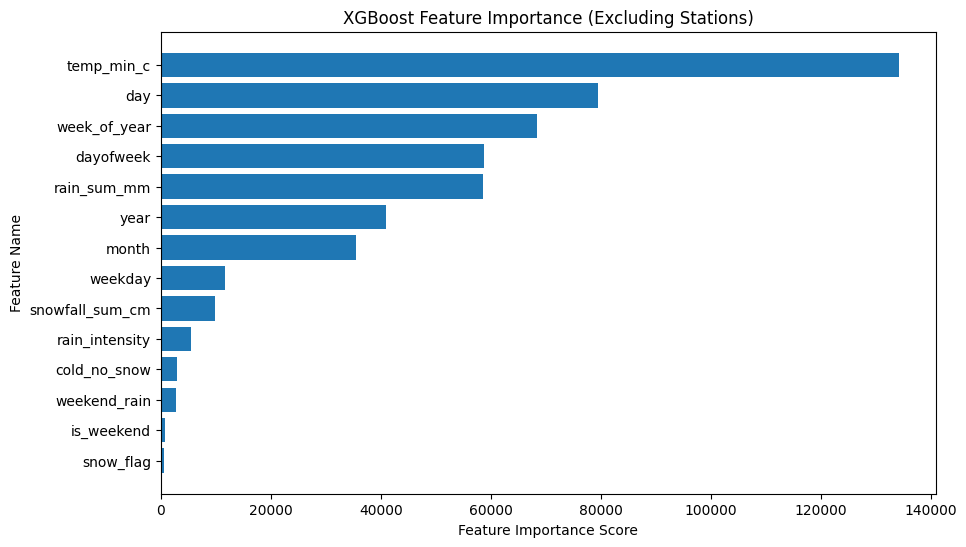

In [ ]:
# Get feature names
feature_names = X_train.columns

# Exclude one-hot encoded station features
filtered_features = [f for f in feature_names if not f.startswith("start_station_name_")]

# Get importance scores only for relevant features
importance = best_xgb_model.get_booster().get_score(importance_type="weight")

# Filter out station one-hot encoding
filtered_importance = {k: v for k, v in importance.items() if k in filtered_features}

# Sort features by importance
sorted_importance = sorted(filtered_importance.items(), key=lambda x: x[1], reverse=True)

# Plot the filtered feature importance
plt.figure(figsize=(10, 6))
plt.barh([x[0] for x in sorted_importance], [x[1] for x in sorted_importance])
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature Name")
plt.title("XGBoost Feature Importance (Excluding Stations)")
plt.gca().invert_yaxis()  # Highest importance at top
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

def identify_stations_with_growth_potential(train_df, test_df, model, year_2023=2023, year_2024=2024):
    """
    Identify stations with highest growth potential based on 2023 vs 2024 forecasted growth.

    Parameters:
    -----------
    train_df : DataFrame
        The training data containing 2023 rides data
    test_df : DataFrame
        The test data for generating 2024 predictions
    model : XGBRegressor
        The trained model for making predictions
    year_2023 : int
        The year for historical data
    year_2024 : int
        The year for forecasted data

    Returns:
    --------
    DataFrame
        A DataFrame containing stations sorted by growth potential
    """
    # Make copies to avoid modifying the original dataframes
    train_df = train_df.copy()
    test_df = test_df.copy()

    # Ensure we have date columns properly converted to datetime
    if 'ds' not in train_df.columns or not pd.api.types.is_datetime64_dtype(train_df['ds']):
        if 'date' in train_df.columns:
            train_df['ds'] = pd.to_datetime(train_df['date'])
        else:
            print("No date column found in training data")
            return None

    if 'ds' not in test_df.columns or not pd.api.types.is_datetime64_dtype(test_df['ds']):
        if 'date' in test_df.columns:
            test_df['ds'] = pd.to_datetime(test_df['date'])
        else:
            print("No date column found in test data")
            return None

    # Print info for debugging
    print(f"Train date range: {train_df['ds'].min()} to {train_df['ds'].max()}")
    print(f"Test date range: {test_df['ds'].min()} to {test_df['ds'].max()}")

    # Filter for 2023 data from training set
    train_2023 = train_df[train_df['ds'].dt.year == year_2023].copy()
    print(f"Found {len(train_2023)} records for year {year_2023}")

    # Calculate station-level metrics for 2023
    station_2023 = train_2023.groupby('start_station_name')['total_rides'].agg(['sum', 'mean', 'count']).reset_index()
    station_2023.columns = ['station', 'total_rides_2023', 'avg_daily_rides_2023', 'days_2023']

    # Generate predictions for 2024 using the test set
    X_test = test_df.drop(['total_rides', 'ds', 'start_station_id'], axis=1, errors='ignore')
    predictions = model.predict(X_test)
    test_df['predicted_rides'] = predictions

    # Group predictions by station for 2024
    test_with_stations = test_df.copy()
    # Check if 'start_station_name' is one-hot encoded
    if 'start_station_name' not in test_with_stations.columns:
        # Reconstruct station names from one-hot encoding
        station_cols = [col for col in test_with_stations.columns if col.startswith('start_station_name_')]

        # Create a mapping function to get station name from one-hot columns
        def get_station_from_onehot(row):
            for col in station_cols:
                if row[col] == 1:
                    return col.replace('start_station_name_', '')
            return None

        # Apply the mapping to get station names
        test_with_stations['start_station_name'] = test_with_stations.apply(get_station_from_onehot, axis=1)

    # Group by station to get 2024 predictions
    station_2024 = test_with_stations.groupby('start_station_name')['predicted_rides'].agg(['sum', 'mean', 'count']).reset_index()
    station_2024.columns = ['station', 'total_rides_2024', 'avg_daily_rides_2024', 'days_2024']

    # Merge 2023 and 2024 data
    station_growth = pd.merge(station_2023, station_2024, on='station', how='inner')

    # Calculate growth metrics
    station_growth['growth_total'] = ((station_growth['total_rides_2024'] - station_growth['total_rides_2023']) /
                                     station_growth['total_rides_2023']) * 100
    station_growth['growth_daily_avg'] = ((station_growth['avg_daily_rides_2024'] - station_growth['avg_daily_rides_2023']) /
                                          station_growth['avg_daily_rides_2023']) * 100

    # For fairness, normalize by the number of days if they differ
    station_growth['days_ratio'] = station_growth['days_2024'] / station_growth['days_2023']
    station_growth['normalized_growth'] = station_growth['growth_total'] / station_growth['days_ratio']

    # Add a weighted score that considers both growth rate and volume
    station_growth['volume_factor'] = np.log10(station_growth['total_rides_2023'] + 1) / np.log10(station_growth['total_rides_2023'].max() + 1)
    station_growth['growth_potential_score'] = station_growth['normalized_growth'] * (0.7 + 0.3 * station_growth['volume_factor'])

    # Sort by growth potential score
    result = station_growth.sort_values('growth_potential_score', ascending=False).reset_index(drop=True)

    return result

def visualize_top_growth_stations(growth_df, top_n=20):
    """
    Visualize the top stations with highest growth potential

    Parameters:
    -----------
    growth_df : DataFrame
        The DataFrame with station growth metrics
    top_n : int
        Number of top stations to display
    """
    # Select top N stations
    top_stations = growth_df.head(top_n).copy()

    # Create a visualization showing growth rates
    plt.figure(figsize=(14, 8))

    # Bar chart of growth rates
    ax = sns.barplot(x='normalized_growth', y='station', data=top_stations, palette='viridis')

    # Add annotations showing actual values
    for i, row in enumerate(top_stations.itertuples()):
        plt.text(row.normalized_growth + 1, i, f"{row.normalized_growth:.1f}%", va='center')

    plt.title(f'Top {top_n} Stations by Forecasted Growth Rate (2023 to 2024)', fontsize=16)
    plt.xlabel('Normalized Growth Rate (%)', fontsize=12)
    plt.ylabel('Station', fontsize=12)
    plt.tight_layout()
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    # Display the plot
    plt.show()

    # Create a scatterplot showing relationship between growth and volume
    plt.figure(figsize=(14, 8))
    scatter = plt.scatter(
        x='total_rides_2023',
        y='normalized_growth',
        s=top_stations['growth_potential_score'] * 5,  # Size represents growth potential score
        c=top_stations.index,  # Color by rank
        cmap='viridis',
        alpha=0.7,
        data=top_stations
    )

    # Add labels for each point
    for i, row in enumerate(top_stations.itertuples()):
        plt.annotate(
            row.station,
            (row.total_rides_2023, row.normalized_growth),
            xytext=(7, 0),
            textcoords='offset points',
            fontsize=9
        )

    plt.title('Growth Rate vs. Current Volume for Top Stations', fontsize=16)
    plt.xlabel('Total Rides in 2023', fontsize=12)
    plt.ylabel('Forecasted Growth Rate (%)', fontsize=12)
    plt.xscale('log')  # Log scale for better visualization
    plt.grid(True, alpha=0.3)
    plt.colorbar(scatter, label='Rank (1 is highest potential)')
    plt.tight_layout()

    # Display the plot
    plt.show()

    return top_stations

# Create a detailed report on growth potential
def generate_growth_potential_report(growth_df, top_n=10):
    """
    Generate a detailed report on stations with highest growth potential

    Parameters:
    -----------
    growth_df : DataFrame
        The DataFrame with station growth metrics
    top_n : int
        Number of top stations to include in the report

    Returns:
    --------
    DataFrame
        A condensed report with key metrics
    """
    # Select top stations
    top_stations = growth_df.head(top_n).copy()

    # Create a formatted report
    report = pd.DataFrame({
        'Rank': range(1, top_n+1),
        'Station': top_stations['station'],
        'Projected Growth (%)': top_stations['normalized_growth'].round(1),
        '2023 Total Rides': top_stations['total_rides_2023'].astype(int),
        '2024 Forecasted Rides': top_stations['total_rides_2024'].round().astype(int),
        'Growth Score': top_stations['growth_potential_score'].round(1)
    })

    # Print the report
    print("\n===== STATION GROWTH POTENTIAL REPORT =====")
    print(f"Top {top_n} Stations with Highest Growth Potential for 2024\n")

    # Display the report
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    print(report)

    print("\nRECOMMENDATIONS:")
    print("1. Focus capacity expansion efforts on these high-potential stations")
    print("2. Implement targeted marketing campaigns in these areas")
    print("3. Consider station upgrades to support anticipated growth")
    print("4. Monitor these stations closely for early signs of increased demand")

    return report

def run_growth_analysis(train_data, test_data, model):
    """
    Wrapper function to run the complete analysis with proper data preparation
    """
    # Make copies to avoid modifying original data
    train_copy = train_data.copy()
    test_copy = test_data.copy()

    # Check if we need to create datetime columns
    if 'ds' not in train_copy.columns and 'date' in train_copy.columns:
        train_copy['ds'] = pd.to_datetime(train_copy['date'])

    if 'ds' not in test_copy.columns and 'date' in test_copy.columns:
        test_copy['ds'] = pd.to_datetime(test_copy['date'])

    # Print data information for debugging
    print("Train shape:", train_copy.shape)
    print("Test shape:", test_copy.shape)
    print("Train columns:", train_copy.columns.tolist())
    print("Test columns:", test_copy.columns.tolist())

    # Check column types
    if 'ds' in train_copy.columns:
        print("Train ds dtype:", train_copy['ds'].dtype)
    if 'ds' in test_copy.columns:
        print("Test ds dtype:", test_copy['ds'].dtype)

    # Identify stations with highest growth potential
    growth_analysis = identify_stations_with_growth_potential(train_copy, test_copy, model)

    if growth_analysis is not None:
        # Visualize the results
        top_growth_stations = visualize_top_growth_stations(growth_analysis)

        # Generate a detailed report
        growth_report = generate_growth_potential_report(growth_analysis)

        return growth_analysis, top_growth_stations, growth_report
    else:
        print("Failed to generate growth analysis due to data issues.")
        return None, None, None

# To run the analysis, execute:
growth_analysis, top_stations, report = run_growth_analysis(train, test, best_xgb_model)

Train shape: (857831, 2094)
Test shape: (253753, 2094)
Train columns: ['total_rides', 'temp_min_c', 'rain_sum_mm', 'snowfall_sum_cm', 'month', 'dayofweek', 'year', 'day', 'weekday', 'week_of_year', 'is_weekend', 'rain_intensity', 'snow_flag', 'weekend_rain', 'cold_no_snow', 'start_station_name_111th St - Morgan Park Metra', 'start_station_name_2112 W Peterson Ave', 'start_station_name_351', 'start_station_name_410', 'start_station_name_532 E 43rd St', 'start_station_name_63rd & Western Ave - north corner', 'start_station_name_63rd & Western Ave - south corner', 'start_station_name_63rd St Beach', 'start_station_name_83rd St (Avalon Park) Metra', 'start_station_name_900 W Harrison St', 'start_station_name_Abbott Park', 'start_station_name_Aberdeen St & Jackson Blvd', 'start_station_name_Aberdeen St & Monroe St', 'start_station_name_Aberdeen St & Randolph St', 'start_station_name_Ada St & 113th St', 'start_station_name_Ada St & 117th St', 'start_station_name_Ada St & 119th St', 'start_st

In [ ]:
growth_analysis

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# XGBoost
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Import ForecastingRecursive from sktime
# Libraries
# ==============================================================================
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load training and test data
train = pd.read_csv("/content/drive/Shared drives/Time Series/divvy_data/prod/station/divvy_station_train.csv")
test = pd.read_csv("/content/drive/Shared drives/Time Series/divvy_data/prod/station/divvy_station_test.csv")

# Ensure dates are in datetime format
train['ds'] = pd.to_datetime(train['date'])
test['ds'] = pd.to_datetime(test['date'])
train.drop(columns=['date'], inplace=True)
test.drop(columns=['date'], inplace=True)

# Create a combined dataframe with a marker column
train['is_train'] = True
test['is_train'] = False
combined = pd.concat([train, test])

# Feature engineering for XGBoost (similar to your original code)
for df in [combined]:
    df['day'] = df['ds'].dt.day
    df['month'] = df['ds'].dt.month
    df['year'] = df['ds'].dt.year
    df['weekday'] = df['ds'].dt.weekday
    df['week_of_year'] = df['ds'].dt.isocalendar().week
    df['is_weekend'] = df['weekday'].isin([5, 6]).astype(int)
    df['rain_intensity'] = pd.cut(df['rain_sum_mm'], bins=[-1, 0, 5, 20, np.inf], labels=[0, 1, 2, 3])
    df['snow_flag'] = (df['snowfall_sum_cm'] > 0).astype(int)
    df['rain_intensity'] = df['rain_intensity'].astype(float)
    df['weekend_rain'] = df['is_weekend'] * df['rain_intensity']
    df['cold_no_snow'] = (df['temp_min_c'] < 5) & (df['snow_flag'] == 0)

# Prepare data for autoregressive approach
# We'll use a station-based approach for demonstration
station_name = combined['start_station_name'].unique()[0]  # Example with first station
station_data = combined[combined['start_station_name'] == station_name].sort_values('ds')

# Create a time series object with the target variable
station_ts = station_data.set_index('ds')['total_rides']

# Create exogenous features
exog_columns = ['temp_min_c', 'temp_max_c', 'rain_sum_mm', 'snowfall_sum_cm',
                'day', 'month', 'year', 'weekday', 'is_weekend',
                'rain_intensity', 'snow_flag', 'weekend_rain', 'cold_no_snow']
X = station_data.set_index('ds')[exog_columns]

# Define train-test split
train_size = int(len(station_ts) * 0.8)
y_train = station_ts[:train_size]
y_test = station_ts[train_size:]
X_train = X[:train_size]
X_test = X[train_size:]

# Create lagged features for autoregressive model
def create_features(y, lags):
    features = pd.DataFrame(index=y.index)

    # Create lag features
    for lag in lags:
        features[f'lag_{lag}'] = y.shift(lag)

    return features

# Define the lags we want to use
lags = [1, 2, 7, 30]

# Create lag features for training
y_train_features = create_features(y_train, lags)
# Drop NaN values at the beginning due to lagging
y_train_features = y_train_features.dropna()
y_train = y_train[y_train_features.index]

# Define XGBoost model with best parameters
best_params = {
    'colsample_bytree': 0.8,
    'learning_rate': 0.1,
    'max_depth': 10,
    'n_estimators': 1000,
    'subsample': 0.8,
    'random_state': 42
}

# Create the base regressor
regressor = XGBRegressor(**best_params)

# Create the autoregressive model with ForecastingRecursive
forecaster = ForecastingRecursive(
    regressor=regressor,
    window_length=max(lags),
    strategy="recursive"
)

# Fit the model
forecaster.fit(y_train)

# Create the forecasting horizon
fh = ForecastingHorizon(y_test.index, is_relative=False)

# Make predictions
y_pred = forecaster.predict(fh)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_train, label='Train')
plt.plot(y_test.index, y_test, label='Test')
plt.plot(y_test.index, y_pred, label='Forecast')
plt.title(f'Autoregressive Forecast for {station_name}')
plt.legend()
plt.show()

# Multi-station approach
# This part shows how to apply the autoregressive approach to multiple stations

# Function to forecast for a specific station
def forecast_station(station_name, combined_df, lags=[1, 2, 7, 30]):
    # Filter data for this station
    station_data = combined_df[combined_df['start_station_name'] == station_name].sort_values('ds')

    # Create time series
    station_ts = station_data.set_index('ds')['total_rides']

    # Create exogenous features
    exog_columns = ['temp_min_c', 'temp_max_c', 'rain_sum_mm', 'snowfall_sum_cm',
                   'day', 'month', 'year', 'weekday', 'is_weekend',
                   'rain_intensity', 'snow_flag', 'weekend_rain', 'cold_no_snow']
    X = station_data.set_index('ds')[exog_columns]

    # Define train-test split point
    train_idx = station_data['is_train'] == True
    y_train = station_ts[train_idx]
    y_test = station_ts[~train_idx]
    X_train = X[train_idx]
    X_test = X[~train_idx]

    # Create lagged features
    y_train_features = create_features(y_train, lags)
    y_train_features = y_train_features.dropna()
    y_train = y_train[y_train_features.index]

    # Define model
    regressor = XGBRegressor(**best_params)

    # Create autoregressive forecaster
    forecaster = ForecastingRecursive(
        regressor=regressor,
        window_length=max(lags),
        strategy="recursive"
    )

    # Fit the model
    forecaster.fit(y_train, X=X_train.loc[y_train.index])

    # Create forecasting horizon
    fh = ForecastingHorizon(y_test.index, is_relative=False)

    # Make predictions
    y_pred = forecaster.predict(fh, X=X_test)

    # Return results
    return y_train, y_test, y_pred

# Example: Apply to a few stations
station_names = combined['start_station_name'].unique()[:3]  # First 3 stations
results = {}

for station in station_names:
    results[station] = forecast_station(station, combined)

    # Plot and evaluate
    y_train, y_test, y_pred = results[station]
    mse = mean_squared_error(y_test, y_pred)

    plt.figure(figsize=(12, 6))
    plt.plot(y_train.index, y_train, label='Train')
    plt.plot(y_test.index, y_test, label='Test')
    plt.plot(y_test.index, y_pred, label='Forecast')
    plt.title(f'Autoregressive Forecast for {station} - MSE: {mse:.2f}')
    plt.legend()
    plt.show()

ValueError: mount failed